In [1]:
import os
import gdown
import pandas as pd
import zipfile
from PIL import Image
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import TensorDataset,Dataset, DataLoader


In [2]:
file_ids = {
    "labels.csv": "1JY6RO6sFtUgrenkEGSkYv9B4alMkTgs9",
    "positionImageDataset.zip": "1WBEnwqc7ABEI5ujkm56s8LlOO9B4Qn8d"
}

download_paths = {
    "labels.csv": "labels.csv",
    "positionImageDataset.zip": "positionImageDataset.zip"
}

# Step 2: Download files
for file_name, file_id in file_ids.items():
    url = f"https://drive.google.com/uc?id={file_id}"
    output_path = download_paths[file_name]
    print(f"Downloading {file_name}...")
    gdown.download(url, output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1JY6RO6sFtUgrenkEGSkYv9B4alMkTgs9
To: /kaggle/working/labels.csv
100%|██████████| 785k/785k [00:00<00:00, 110MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=1WBEnwqc7ABEI5ujkm56s8LlOO9B4Qn8d
From (redirected): https://drive.google.com/uc?id=1WBEnwqc7ABEI5ujkm56s8LlOO9B4Qn8d&confirm=t&uuid=df3f6636-444f-4671-9439-f3d6933c6f2d
To: /kaggle/working/positionImageDataset.zip
100%|██████████| 652M/652M [00:10<00:00, 60.4MB/s] 


In [14]:
# Step 3: Extract ZIP
zip_path = download_paths["positionImageDataset.zip"]
extracted_folder = "positionImageDataset"
if os.path.exists(zip_path):
    print("Extracting positionImageDataset.zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)
    print(f"Extracted to folder: {extracted_folder}")

# Step 4: Load labels.csv
csv_path = download_paths["labels.csv"]
if os.path.exists(csv_path):
    print("Loading labels.csv...")
    labels = pd.read_csv(csv_path)
else:
    raise FileNotFoundError(f"CSV file {csv_path} not found!")

Extracting positionImageDataset.zip...
Extracted to folder: positionImageDataset
Loading labels.csv...


In [26]:
labels.isna().sum()

PositionImage_FileName                            0
Room Ligiting                                     0
Both hands on table?                              0
Can able to see student along with full table?    0
Computer Screen Visible?                          0
Final Decision for uploaded Image                 0
dtype: int64

In [17]:
# Step 5: Process labels.csv
df = labels.copy()

# Define mappings for categorical labels
label_mappings = {
    'Room Ligiting': {'Visible': 1, 'Dark': 0},
    'Both hands on table?': {'Yes': 1, 'No': 0},
    'Can able to see student along with full table?': {'Yes': 1, 'No': 0},
    'Computer Screen Visible?': {'Yes': 1, 'No': 0},
    'Final Decision for uploaded Image': {'Approved': 1, 'Rejected': 0}
}

# Apply mappings to convert categorical labels to numeric
for column, mapping in label_mappings.items():
    df[column] = df[column].map(mapping)

# Calculate counts and percentages
total_images = len(df)
results = {
    "Label": [],
    "Count (1s)": [],
    "Percentage (1s) (%)": [],
    "Count (0s)": [],
    "Percentage (0s) (%)": []
}

for column in df.columns[1:]:  # Exclude 'PositionImage_FileName'
    count_1s = df[column].sum()  # Count of 1s
    percentage_1s = (count_1s / total_images) * 100
    count_0s = total_images - count_1s  # Count of 0s
    percentage_0s = (count_0s / total_images) * 100

    results["Label"].append(column)
    results["Count (1s)"].append(count_1s)
    results["Percentage (1s) (%)"].append(round(percentage_1s, 2))
    results["Count (0s)"].append(count_0s)
    results["Percentage (0s) (%)"].append(round(percentage_0s, 2))

results_df = pd.DataFrame(results)
# print("Processed Labels Summary:")
# print(results_df)

In [27]:
results_df

,Label,Count (1s),Percentage (1s) (%),Count (0s),Percentage (0s) (%)
0,Room Ligiting,10238.0,91.48,954.0,8.52
1,Both hands on table?,8865.0,79.21,2327.0,20.79
2,Can able to see student along with full table?,9635.0,86.09,1557.0,13.91
3,Computer Screen Visible?,9478.0,84.69,1714.0,15.31
4,Final Decision for uploaded Image,7989.0,71.38,3203.0,28.62


In [35]:
# Step 6: Define PyTorch Dataset
class PositionalImageDataset(Dataset):
    def __init__(self, image_dir, labels_csv, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(labels_csv).fillna('Yes')
        self.transform = transform
        self.label_mappings = {
            'Room Ligiting': {'Visible': 1, 'Dark': 0},
            'Both hands on table?': {'Yes': 1, 'No': 0},
            'Can able to see student along with full table?': {'Yes': 1, 'No': 0},
            'Computer Screen Visible?': {'Yes': 1, 'No': 0},
            'Final Decision for uploaded Image': {'Approved': 1, 'Rejected': 0}
        }

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        try:
            img_name = self.labels.iloc[idx, 0]
            img_path = os.path.join(self.image_dir, img_name)

            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            row = self.labels.iloc[idx, 1:]
            encoded_labels = []
            for column_name, mapping in self.label_mappings.items():
                value = row[column_name]
                if value not in mapping:
                    raise ValueError(f"Unexpected value '{value}' in column '{column_name}'.")
                encoded_labels.append(mapping[value])
            encoded_labels = torch.tensor(encoded_labels, dtype=torch.float32)

            attribute_labels = encoded_labels[:-1]
            final_label = encoded_labels[-1]
            return image, attribute_labels, final_label

        except Exception as e:
            print(f"Error at index {idx}: {e}")
            raise



# Step 7: Initialize Dataset and DataLoader
image_dir = os.path.join(extracted_folder, "positionImageDataset")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = PositionalImageDataset(image_dir=image_dir, labels_csv=csv_path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Debugging: Print shapes of one batch
for images, attribute_labels, final_labels in train_loader:
    print("Image Batch Shape:", images.shape)
    print("Attribute Labels Shape:", attribute_labels.shape)
    print("Final Labels Shape:", final_labels.shape)
    break

Image Batch Shape: torch.Size([32, 3, 240, 240])
Attribute Labels Shape: torch.Size([32, 4])
Final Labels Shape: torch.Size([32])


In [36]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(y_true, y_pred):
    """
    Computes accuracy, recall, precision, and F1 score.
    Args:
        y_true (torch.Tensor): True labels.
        y_pred (torch.Tensor): Predicted probabilities or logits.
    Returns:
        dict: Dictionary containing the metrics.
    """
    # Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).int()
    
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
    }


In [37]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, output_features):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (32, 240, 240)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 120, 120)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 120, 120)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 60, 60)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 60, 60)
            # nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1),  # (128, 60, 60)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (128, 30, 30)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 30 * 30, output_features),  # Match flattened size
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # print("After conv_layers:", x.shape)  # Check shape here
        x = self.fc(x)
        # print("After fc:", x.shape)           # Check shape here
        return x


# Base Model with Custom CNN
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.backbone = CustomCNN(output_features=128)  # Extract 128 features
        self.classifier = nn.Linear(128, 1)  # Single output for binary classification

    def forward(self, x):
        features = self.backbone(x)
        return torch.sigmoid(self.classifier(features))  # Output probability for each class

# Initialize base models with Custom CNN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_models = [BaseModel().to(device) for _ in range(4)]

# Meta Model with Custom CNN
class MetaModel(nn.Module):
    def __init__(self):
        super(MetaModel, self).__init__()
        # Convolutional backbone for the image input
        self.image_backbone = CustomCNN(output_features=128)  # Extract 128 features
        
        # Fully connected layers to combine image features and base model outputs
        self.fc = nn.Sequential(
            nn.Linear(128 + 4, 64),  # 128 (image features) + 4 (base model outputs)
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: Final decision
        )

    def forward(self, image, base_outputs):
        # Extract features from the image
        image_features = self.image_backbone(image)  # Shape: [batch_size, 128]
        
        # Concatenate image features and base model outputs
        combined = torch.cat([image_features, base_outputs], dim=1)  # Shape: [batch_size, 128 + 4]
        
        # Predict final decision
        return torch.sigmoid(self.fc(combined))  # Output probability


In [38]:
def train_and_evaluate(base_models, train_loader, val_loader, device, epochs=5, lr=0.001):
    """
    Trains base models and evaluates metrics.
    Args:
        base_models (list): List of models to train and evaluate.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        device (str): 'cuda' or 'cpu'.
        epochs (int): Number of epochs to train.
        lr (float): Learning rate for the optimizer.
    Returns:
        list: A list containing dictionaries with loss and metrics for each model.
    """
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    results = []  # To store results for each model

    for i, base_model in enumerate(base_models):
        optimizer = torch.optim.Adam(base_model.parameters(), lr=lr)
        model_results = {"loss": [], "metrics": []}  # To store epoch-wise results

        for epoch in range(epochs):
            # Training
            base_model.train()
            running_loss = 0.0
            for images, attribute_labels, _ in train_loader:
                images, attribute_labels = images.to(device), attribute_labels.to(device)
                labels = attribute_labels[:, i:i+1]  # Select the i-th attribute column

                optimizer.zero_grad()
                outputs = base_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            model_results["loss"].append(avg_loss)

            # Validation
            base_model.eval()
            all_labels, all_predictions = [], []
            with torch.no_grad():
                for images, attribute_labels, _ in val_loader:
                    images, attribute_labels = images.to(device), attribute_labels.to(device)
                    labels = attribute_labels[:, i:i+1]
                    outputs = base_model(images)
                    all_labels.append(labels.cpu())
                    all_predictions.append(outputs.cpu())

            # Concatenate and compute metrics
            all_labels = torch.cat(all_labels)
            all_predictions = torch.cat(all_predictions)
            metrics = compute_metrics(all_labels, all_predictions)
            model_results["metrics"].append(metrics)

            # Print progress
            print(f"Base Model {i+1}, Epoch {epoch+1}: Loss: {avg_loss:.4f}, Metrics: {metrics}")
        
        results.append(model_results)

    return results


In [39]:
import matplotlib.pyplot as plt
def plot_all_models(results):
    """
    Plots training loss and metrics for all models.
    Args:
        results (list): List of dictionaries containing loss and metrics for each model.
    """
    for i, model_results in enumerate(results):
        epochs = len(model_results["loss"])
        epoch_range = range(1, epochs + 1)
        
        # Extract losses and metrics
        losses = model_results["loss"]
        accuracies = [m["accuracy"] for m in model_results["metrics"]]
        recalls = [m["recall"] for m in model_results["metrics"]]
        precisions = [m["precision"] for m in model_results["metrics"]]
        f1_scores = [m["f1"] for m in model_results["metrics"]]

        # Create subplots
        plt.figure(figsize=(15, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epoch_range, losses, label="Loss", color="blue", marker="o")
        plt.title(f"Model {i+1}: Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.legend()

        # Plot Metrics
        plt.subplot(1, 2, 2)
        plt.plot(epoch_range, accuracies, label="Accuracy", marker="o")
        plt.plot(epoch_range, recalls, label="Recall", marker="s")
        plt.plot(epoch_range, precisions, label="Precision", marker="^")
        plt.plot(epoch_range, f1_scores, label="F1 Score", marker="d")
        plt.title(f"Model {i+1}: Validation Metrics")
        plt.xlabel("Epoch")
        plt.ylabel("Score")
        plt.grid(True)
        plt.legend()

        # Display the plots
        plt.tight_layout()
        plt.show()


In [40]:
results = train_and_evaluate(
    base_models=base_models,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,
    lr=0.001
)


Base Model 1, Epoch 1: Loss: 8.6776, Metrics: {'accuracy': 0.9222867351496203, 'recall': 1.0, 'precision': 0.9222867351496203, 'f1': 0.9595724907063197}
Base Model 1, Epoch 2: Loss: 8.7116, Metrics: {'accuracy': 0.9222867351496203, 'recall': 1.0, 'precision': 0.9222867351496203, 'f1': 0.9595724907063197}
Base Model 1, Epoch 3: Loss: 8.7085, Metrics: {'accuracy': 0.9222867351496203, 'recall': 1.0, 'precision': 0.9222867351496203, 'f1': 0.9595724907063197}
Base Model 1, Epoch 4: Loss: 8.7116, Metrics: {'accuracy': 0.9222867351496203, 'recall': 1.0, 'precision': 0.9222867351496203, 'f1': 0.9595724907063197}
Base Model 1, Epoch 5: Loss: 8.7116, Metrics: {'accuracy': 0.9222867351496203, 'recall': 1.0, 'precision': 0.9222867351496203, 'f1': 0.9595724907063197}
Base Model 1, Epoch 6: Loss: 8.7147, Metrics: {'accuracy': 0.9222867351496203, 'recall': 1.0, 'precision': 0.9222867351496203, 'f1': 0.9595724907063197}
Base Model 1, Epoch 7: Loss: 8.7116, Metrics: {'accuracy': 0.9222867351496203, 're

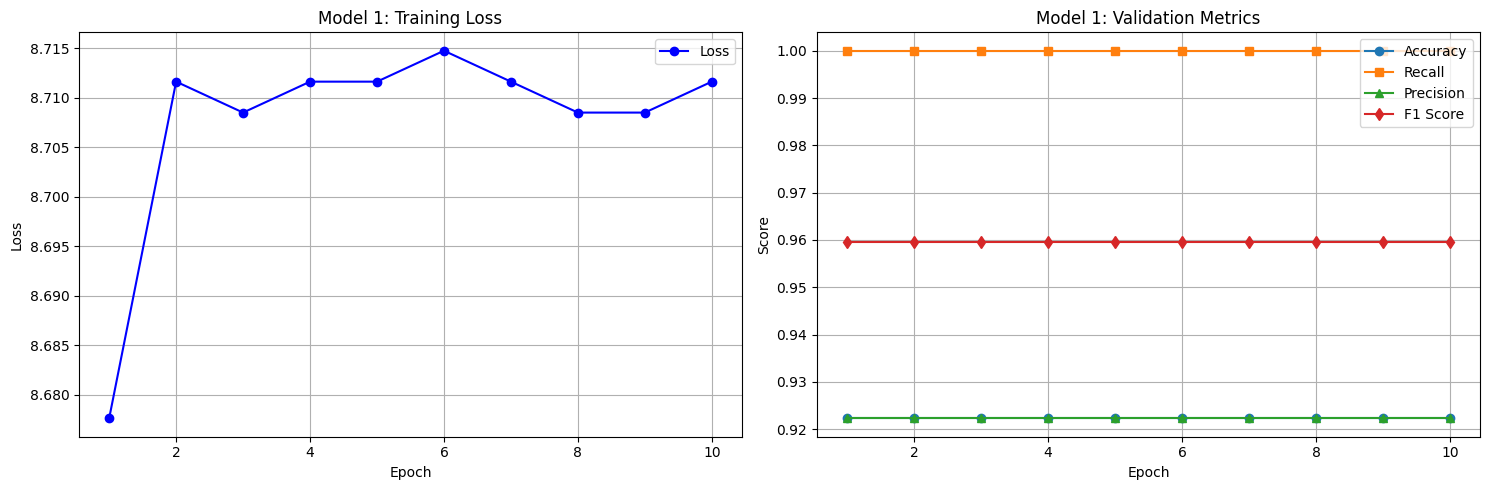

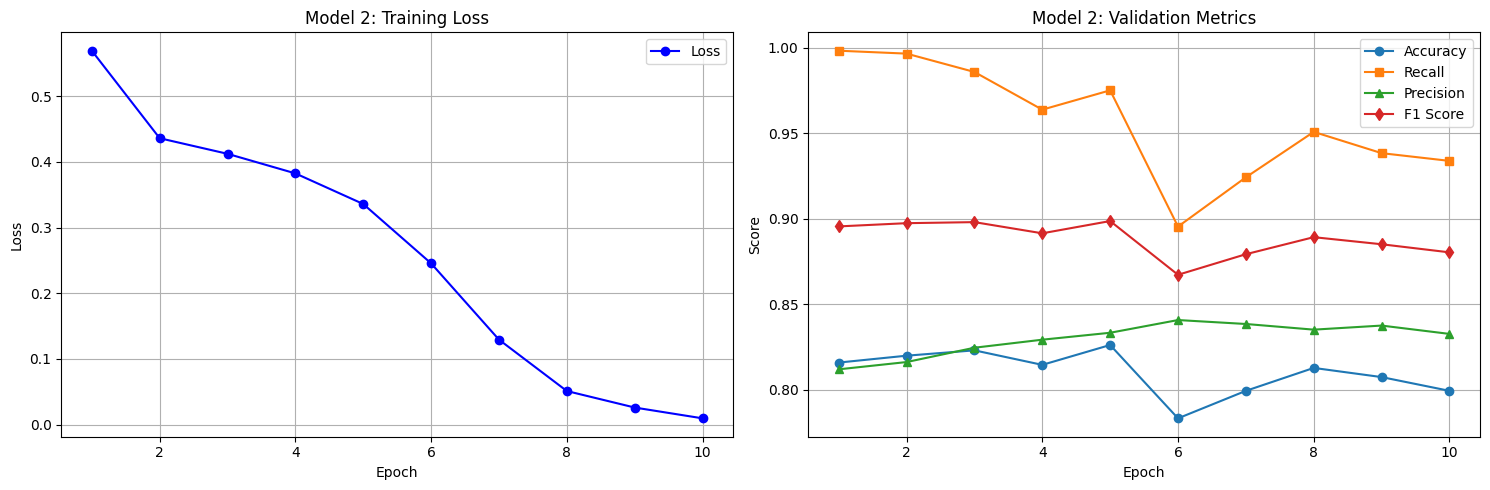

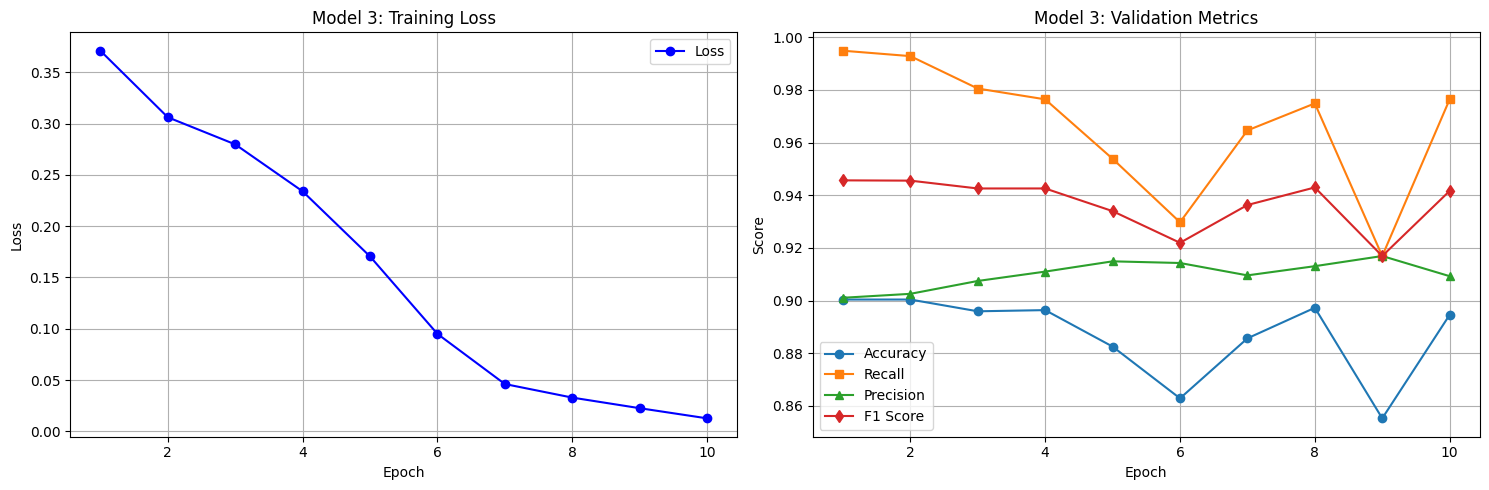

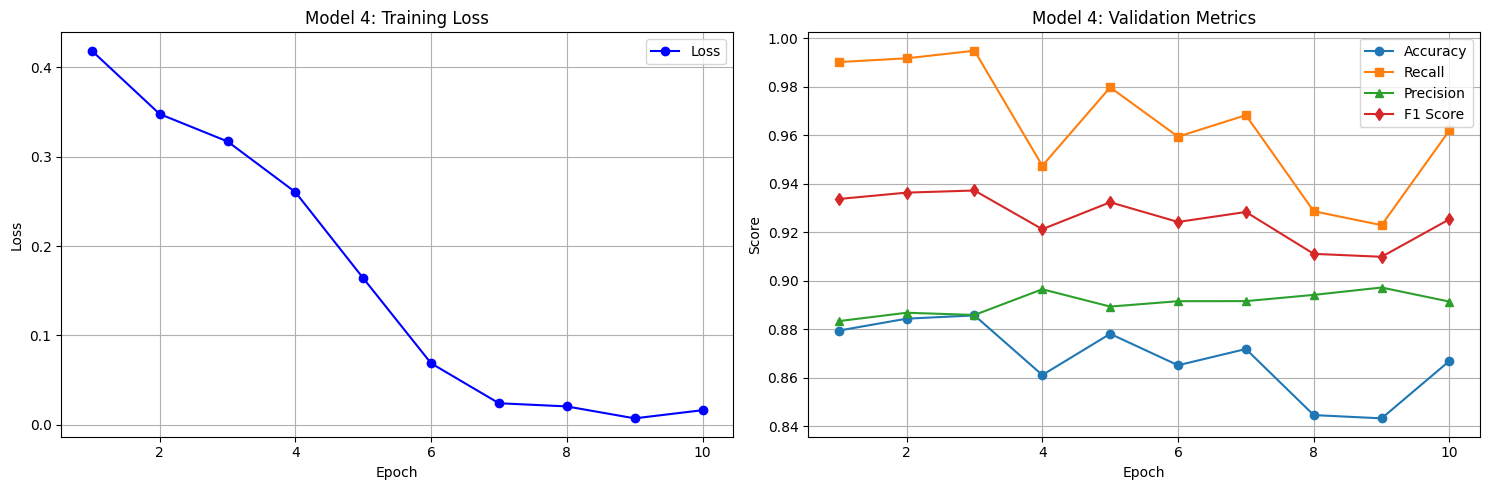

In [41]:
plot_all_models(results)


In [43]:
def collect_base_outputs(base_models, loader, device='cuda'):
    meta_inputs = []
    meta_labels = []
    all_images = []  # Store images for later use

    for batch_idx, (images, attribute_labels, final_labels) in enumerate(loader):
        print(f"Processing batch {batch_idx + 1}/{len(loader)}")
        
        # Move labels to GPU (images will be processed per model)
        final_labels = final_labels.to(device)
        all_images.append(images.cpu())  # Keep images on CPU for now
        
        # Collect outputs for all base models
        base_outputs = []
        for model_idx, model in enumerate(base_models):
            model = model.to(device)  # Ensure the model is on the device
            
            # Process images batch for this model
            with torch.no_grad():
                outputs = model(images.to(device)).detach().cpu()  # Compute and move to CPU
                base_outputs.append(outputs)
                # print(f"Base model {model_idx + 1} outputs collected.")
        
        # Concatenate outputs for all base models
        base_outputs = torch.cat(base_outputs, dim=1)  # Concatenate all base outputs
        meta_inputs.append(base_outputs)  # Store only base outputs
        meta_labels.append(final_labels.cpu())  # Move labels to CPU
        
        # # Clean up GPU memory after processing all models for the current batch
        # del images, attribute_labels, final_labels, outputs, base_outputs
        # torch.cuda.empty_cache()
    
    # Return the collected meta inputs, labels, and images
    return torch.cat(meta_inputs), torch.cat(meta_labels), torch.cat(all_images)


In [44]:

# Prepare meta-model training data
meta_inputs, meta_labels, images = collect_base_outputs(base_models, train_loader)

# Create a dataset with images, meta_inputs, and labels
meta_dataset = TensorDataset(images, meta_inputs, meta_labels)

# Use DataLoader with a smaller batch size
meta_loader = DataLoader(meta_dataset, batch_size=32, shuffle=True)


Processing batch 1/280
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 2/280
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 3/280
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 4/280
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 5/280
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 6/280
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 7/280
Base model 1 outputs collected.
Base model 2 outputs collected.
Base mo

In [45]:
# Prepare meta-model training data
meta_inputs, meta_labels, images = collect_base_outputs(base_models, val_loader)

# Create a dataset with images, meta_inputs, and labels
meta_val_dataset = TensorDataset(images, meta_inputs, meta_labels)

# Use DataLoader with a smaller batch size
meta_val_loader = DataLoader(meta_dataset, batch_size=32, shuffle=True)

Processing batch 1/70
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 2/70
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 3/70
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 4/70
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 5/70
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 6/70
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 outputs collected.
Base model 4 outputs collected.
Processing batch 7/70
Base model 1 outputs collected.
Base model 2 outputs collected.
Base model 3 o

In [47]:
from tqdm import tqdm

def train_meta_model(meta_model, meta_loader, meta_val_loader, meta_optimizer, criterion, device, num_epochs=10):
    """
    Train the meta-model and collect metrics for plotting.
    
    Args:
        meta_model: The meta-model to train.
        meta_loader: DataLoader for training data.
        meta_val_loader: DataLoader for validation data.
        meta_optimizer: Optimizer for the meta-model.
        criterion: Loss function.
        device: Device to use for training (e.g., 'cuda' or 'cpu').
        num_epochs: Number of epochs to train for.

    Returns:
        results: A dictionary containing training losses and metrics for each epoch.
    """
    results = {"loss": [], "metrics": []}

    for epoch in range(num_epochs):
        # Training phase
        meta_model.train()
        total_loss = 0
        # torch.cuda.empty_cache()  # Clean GPU memory

        print(f"Epoch {epoch+1}/{num_epochs} - Training Phase")
        train_loader_tqdm = tqdm(meta_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, base_outputs, labels in train_loader_tqdm:
            images, base_outputs, labels = images.to(device), base_outputs.to(device), labels.to(device)

            meta_optimizer.zero_grad()
            outputs = meta_model(images, base_outputs).squeeze(-1)  # Pass both images and base_outputs
            loss = criterion(outputs, labels)
            loss.backward()
            meta_optimizer.step()

            total_loss += loss.item()

            # Update tqdm with batch loss
            train_loader_tqdm.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(meta_loader)
        results["loss"].append(avg_loss)
        print(f"Meta Model Epoch {epoch+1}: Average Training Loss: {avg_loss:.4f}")

        # Validation phase
        meta_model.eval()
        all_labels = []
        all_predictions = []
        # torch.cuda.empty_cache()  # Clean GPU memory

        print(f"Epoch {epoch+1}/{num_epochs} - Validation Phase")
        val_loader_tqdm = tqdm(meta_val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", leave=False)

        with torch.no_grad():
            for images, base_outputs, labels in val_loader_tqdm:
                images, base_outputs, labels = images.to(device), base_outputs.to(device), labels.to(device)
                outputs = meta_model(images, base_outputs)  # Pass both images and base_outputs
                all_labels.append(labels.cpu())
                all_predictions.append(outputs.cpu())

        # Compute metrics
        all_labels = torch.cat(all_labels)
        all_predictions = torch.cat(all_predictions)
        metrics = compute_metrics(all_labels, all_predictions)
        results["metrics"].append(metrics)
        print(f"Meta Model Epoch {epoch+1}: Validation Metrics: {metrics}")

    return results


In [49]:
# Initialize the Meta Model
meta_model = MetaModel().to(device)  # Ensure the model is moved to the correct device

# Define optimizer and loss function
meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=1e-4)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification

# Train the meta-model and collect results
results = train_meta_model(
    meta_model=meta_model,
    meta_loader=meta_loader,
    meta_val_loader = meta_val_loader,
    meta_optimizer=meta_optimizer,
    criterion=criterion,
    device=device,
    num_epochs=10
)

Epoch 1/10 - Training Phase


Meta Model Epoch 1: Average Training Loss: 0.5451
Epoch 1/10 - Validation Phase


Meta Model Epoch 1: Validation Metrics: {'accuracy': 0.7585166983134145, 'recall': 0.9854368932038835, 'precision': 0.7525711552260225, 'f1': 0.8534038513696772}
Epoch 2/10 - Training Phase


Meta Model Epoch 2: Average Training Loss: 0.4973
Epoch 2/10 - Validation Phase


Meta Model Epoch 2: Validation Metrics: {'accuracy': 0.7939238244163968, 'recall': 0.9879423739430003, 'precision': 0.7811068466014609, 'f1': 0.8724331051649036}
Epoch 3/10 - Training Phase


Meta Model Epoch 3: Average Training Loss: 0.4542
Epoch 3/10 - Validation Phase


Meta Model Epoch 3: Validation Metrics: {'accuracy': 0.8437395286496147, 'recall': 0.9660194174757282, 'precision': 0.83920555026527, 'f1': 0.8981582587173328}
Epoch 4/10 - Training Phase


Meta Model Epoch 4: Average Training Loss: 0.4030
Epoch 4/10 - Validation Phase


Meta Model Epoch 4: Validation Metrics: {'accuracy': 0.8440746118619458, 'recall': 0.9915440025054807, 'precision': 0.8251237946312223, 'f1': 0.9007112375533427}
Epoch 5/10 - Training Phase


Meta Model Epoch 5: Average Training Loss: 0.3422
Epoch 5/10 - Validation Phase


Meta Model Epoch 5: Validation Metrics: {'accuracy': 0.8931084552663912, 'recall': 0.9907610397745067, 'precision': 0.8757093425605537, 'f1': 0.9296892219528322}
Epoch 6/10 - Training Phase


Meta Model Epoch 6: Average Training Loss: 0.2576
Epoch 6/10 - Validation Phase


Meta Model Epoch 6: Validation Metrics: {'accuracy': 0.9546520719311963, 'recall': 0.9942060757907923, 'precision': 0.9450729383745162, 'f1': 0.969017094017094}
Epoch 7/10 - Training Phase


Meta Model Epoch 7: Average Training Loss: 0.1717
Epoch 7/10 - Validation Phase


Meta Model Epoch 7: Validation Metrics: {'accuracy': 0.9150005584720206, 'recall': 1.0, 'precision': 0.8935217573807192, 'f1': 0.9437670878593069}
Epoch 8/10 - Training Phase


Meta Model Epoch 8: Average Training Loss: 0.0913
Epoch 8/10 - Validation Phase


Meta Model Epoch 8: Validation Metrics: {'accuracy': 0.9918463084999442, 'recall': 0.9943626683369872, 'precision': 0.9942069829340848, 'f1': 0.9942848195412197}
Epoch 9/10 - Training Phase


Meta Model Epoch 9: Average Training Loss: 0.0394
Epoch 9/10 - Validation Phase


Meta Model Epoch 9: Validation Metrics: {'accuracy': 0.997766111917793, 'recall': 0.9995302223614156, 'precision': 0.99734375, 'f1': 0.9984357891443767}
Epoch 10/10 - Training Phase


Meta Model Epoch 10: Average Training Loss: 0.0209
Epoch 10/10 - Validation Phase


Meta Model Epoch 10: Validation Metrics: {'accuracy': 0.9996649167876689, 'recall': 0.9995302223614156, 'precision': 1.0, 'f1': 0.999765055994988}


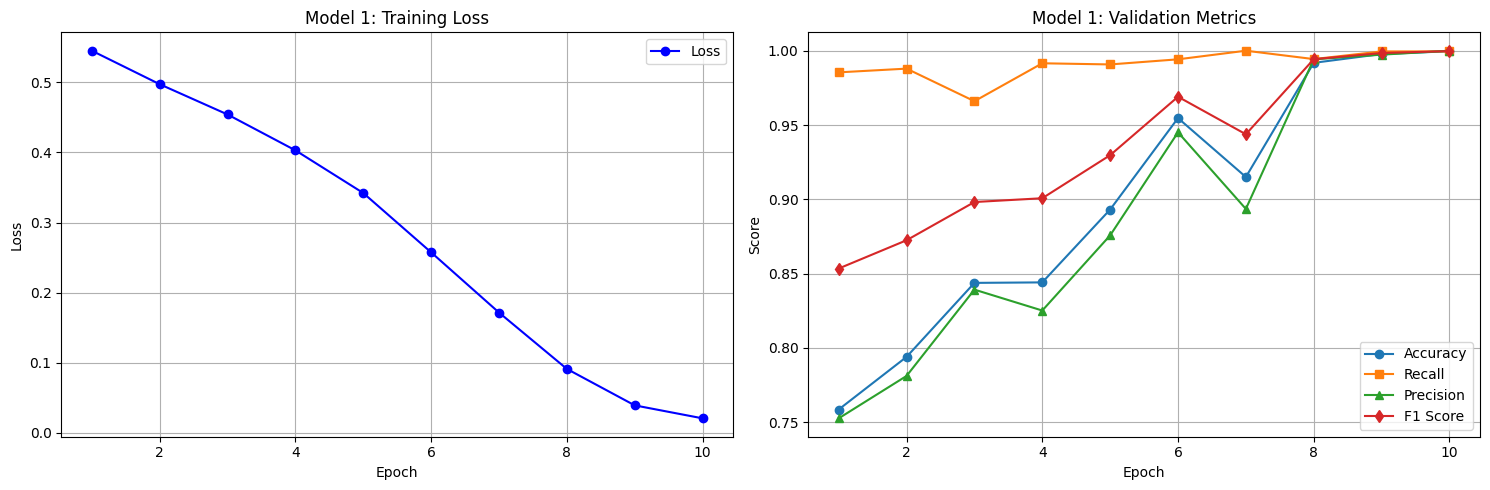

In [50]:
# Plot the training loss and metrics
plot_all_models([results])
